# 1. Load libraries and create some functions

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []
    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Purples", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)
    
    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)
    
    # Plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model(base_model, transfer_learning):
    """
    Constructs and returns a neural network model tailored for binary classification of grayscale images. 

    This function adapts a given base model for grayscale input by adding a custom input layer and a Conv2D 
    layer to convert the single-channel input into a three-channel format compatible with the base model. 
    The base model can be set as trainable or non-trainable based on the 'transfer_learning' parameter. 
    When transfer learning is enabled ('Y'), all layers of the base model are frozen; otherwise, they are 
    left trainable ('N'). 

    The network is extended with three additional custom dense layers for feature processing and classification. 
    The final output layer uses a sigmoid activation function, making the model suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-trained model to be used as the starting point.
    - transfer_learning (str): A flag indicating whether to enable ('Y') or disable ('N') transfer learning by freezing the base model.

    Returns:
    - keras.Model: The constructed binary classification model.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the MobileNet model
    x = base_model(x)

    # Add own top layers for classification
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# 2. Load data

In [7]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 748 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


# 3. Class Weights

In [8]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.06016042780748665, 1: 0.9398395721925134}

# 4. VGG16 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## 4.2. Train Placenta Classifier (fine-tuning from previous model)

In [10]:
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

base_model.trainable set to False


In [12]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7d00c4183d00> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d00c4191e40> True
<keras.src.engine.functional.Functional object at 0x7d00c4183880> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d00c656c1c0> True
<keras.src.layers.core.dense.Dense object at 0x7d00c4193160> True
<keras.src.layers.core.dense.Dense object at 0x7d00c4193a90> True
<keras.src.layers.core.dense.Dense object at 0x7d00c41d8d30> True


In [13]:
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

In [14]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

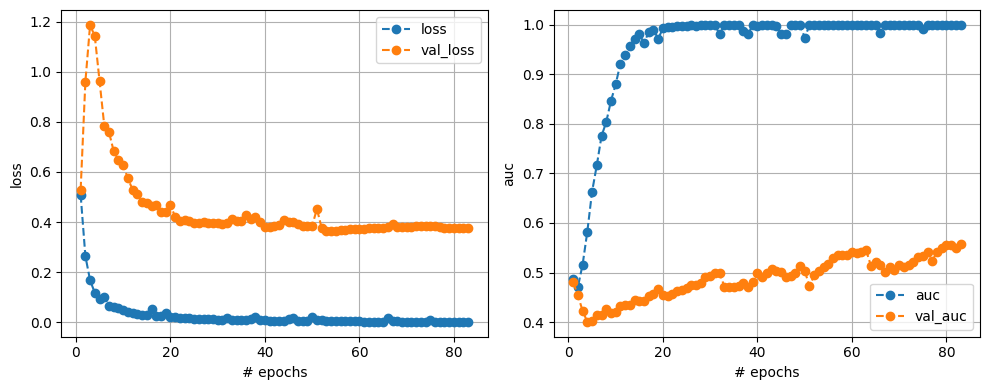

24/24 [==============================] - 6s 207ms/step - loss: 0.0023 - auc: 1.0000 - val_loss: 0.3763 - val_auc: 0.5567
Training time: 562.7831037044525 seconds


In [15]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Max Sensitivity at Specificity >= 0.93: 0.08


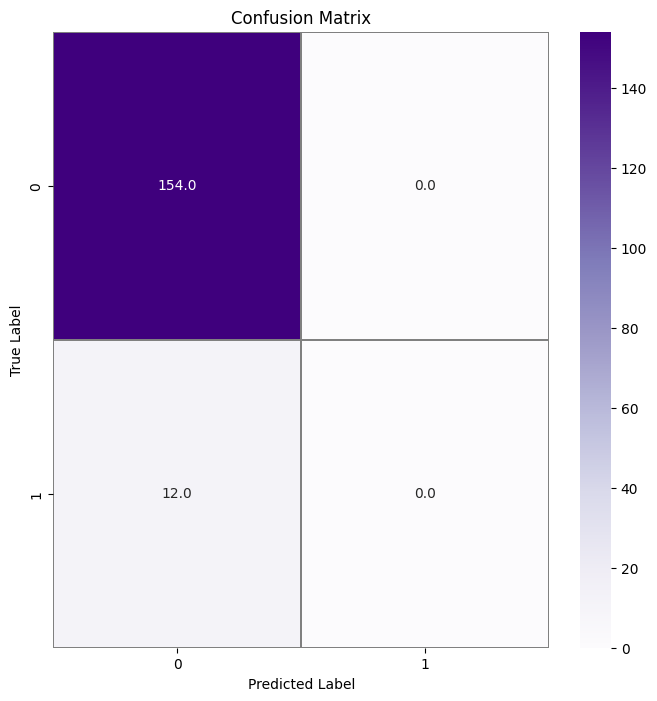

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

  Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0   VGG16-TL                                 0.08  0.43   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


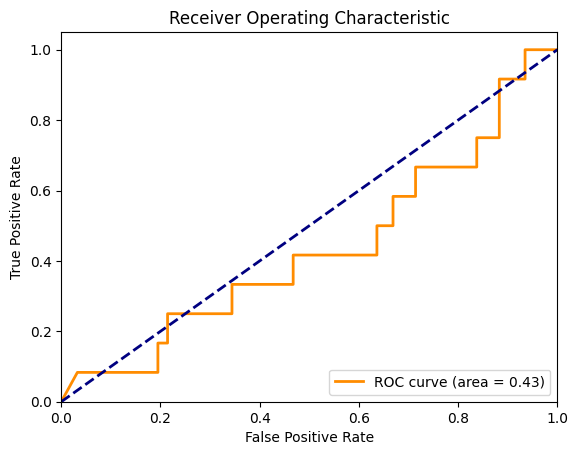

In [16]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL')

## 4.3. Train Placenta Classifier with IMG AUG (fine-tuning from previous model)

In [17]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

In [18]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [19]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfffc480850> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cfffc480790> True
<keras.src.engine.functional.Functional object at 0x7d00c4183880> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d005e1b3df0> True
<keras.src.layers.core.dense.Dense object at 0x7cfffc481960> True
<keras.src.layers.core.dense.Dense object at 0x7cfffc481780> True
<keras.src.layers.core.dense.Dense object at 0x7cfffc4806d0> True


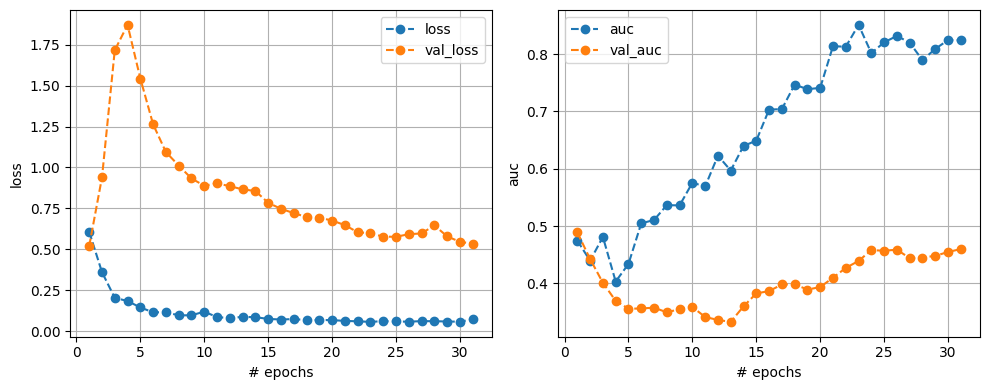

24/24 [==============================] - 6s 211ms/step - loss: 0.0724 - auc: 0.8241 - val_loss: 0.5348 - val_auc: 0.4600
Training time: 212.082834482193 seconds


In [20]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Max Sensitivity at Specificity >= 0.93: 0.17


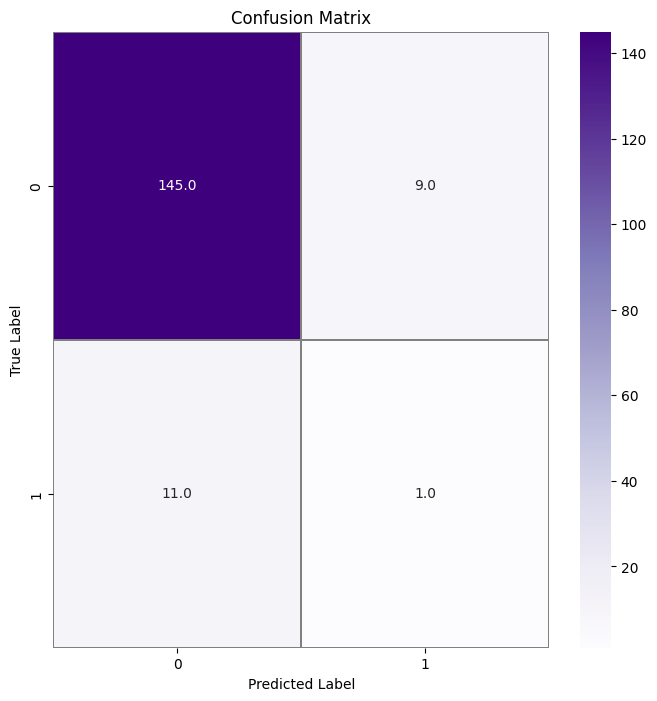

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       154
           1       0.10      0.08      0.09        12

    accuracy                           0.88       166
   macro avg       0.51      0.51      0.51       166
weighted avg       0.87      0.88      0.87       166

     Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  VGG16-TL-AUG                                 0.17  0.52   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                     0.09      0.88         0.08         0.94  0.1  0.93   

    PLR   NLR  
0  1.43  0.97  


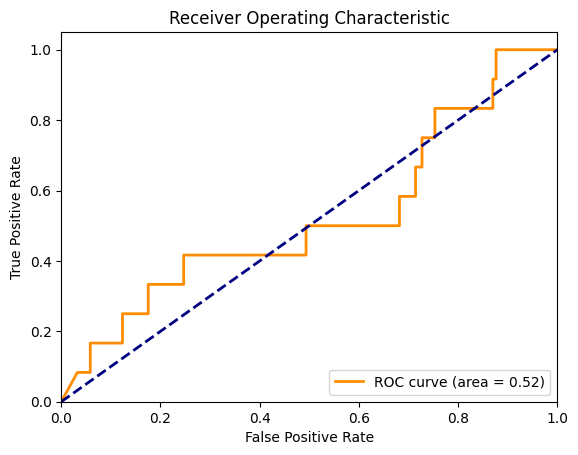

In [21]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL-AUG')

## 4.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

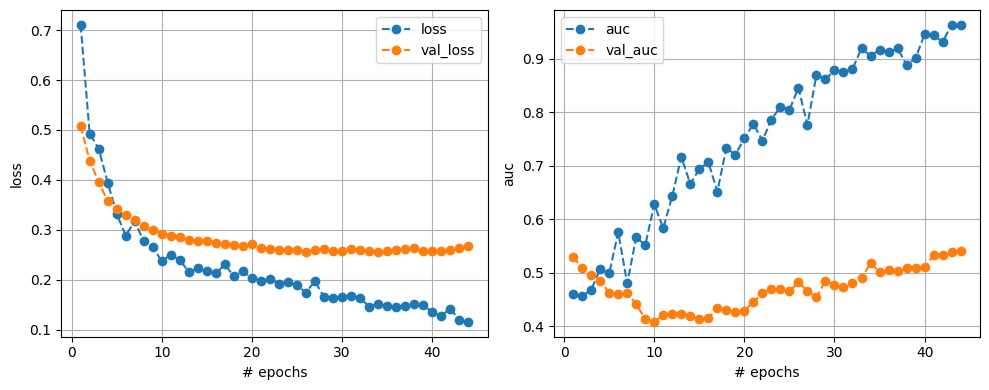

24/24 [==============================] - 6s 221ms/step - loss: 0.1157 - auc: 0.9625 - val_loss: 0.2682 - val_auc: 0.5411
Training time: 302.92279410362244 seconds


In [22]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

# Unfreeze four top layers 
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)


# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      #class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Max Sensitivity at Specificity >= 0.93: 0.08


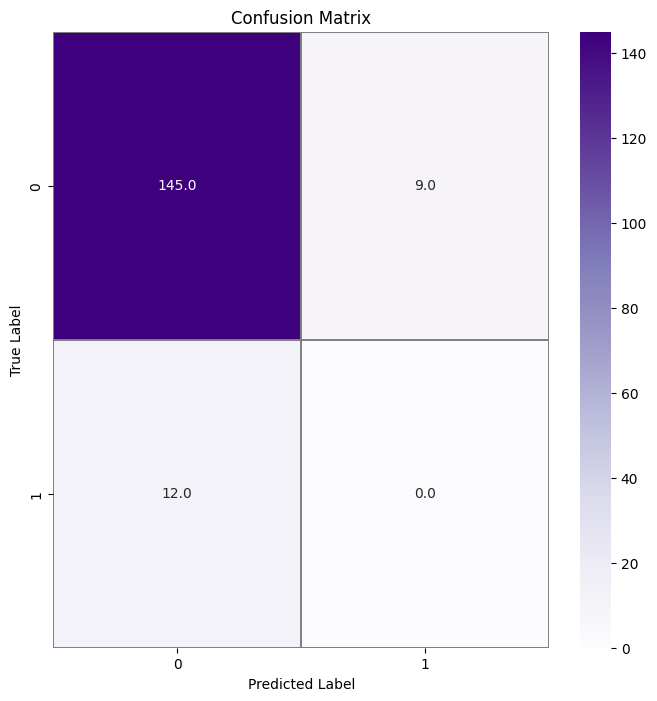

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       154
           1       0.00      0.00      0.00        12

    accuracy                           0.87       166
   macro avg       0.46      0.47      0.47       166
weighted avg       0.86      0.87      0.87       166

           Model Name  Max Sensitivity at Specificity 0.93  AUC  \
0  VGG16-TL-AUG-no-CW                                 0.08  0.4   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.87          0.0         0.94  0.0  0.92   

   PLR   NLR  
0  0.0  1.06  


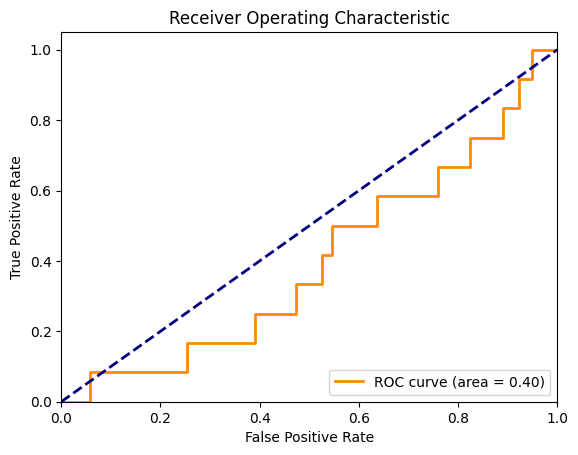

In [23]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL-AUG-no-CW')

# 4B. VGG16 NO Transfer Learning

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. Four additional custom layers are added and no layers are frozen. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from the brain classifier, and then 4 layers to fine tune the placenta images.

## 4B.2. Train Placenta Classifier (fine-tuning from previous model)

In [24]:
## Placenta classifier
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

base_model.trainable set to False


In [25]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7d004bd01ea0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d00b00693c0> True
<keras.src.engine.functional.Functional object at 0x7d004bd027d0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d00b00688e0> True
<keras.src.layers.core.dense.Dense object at 0x7d00b0068310> True
<keras.src.layers.core.dense.Dense object at 0x7d0038132c20> True
<keras.src.layers.core.dense.Dense object at 0x7d00381306a0> True


In [26]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

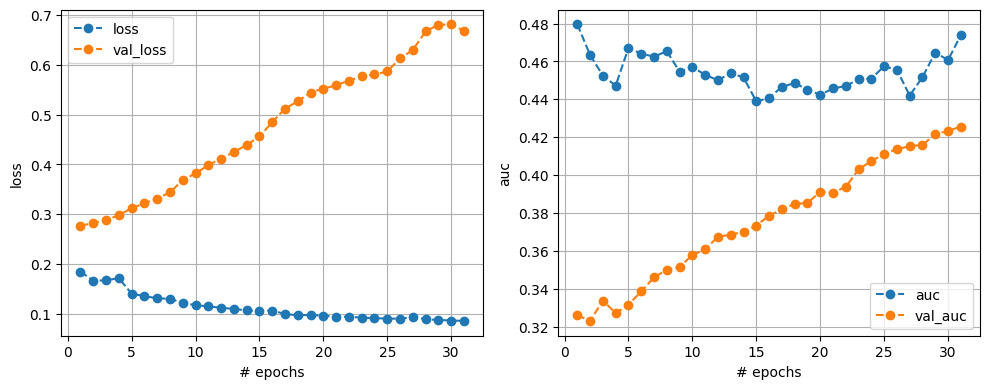

24/24 [==============================] - 6s 215ms/step - loss: 0.0861 - auc: 0.4739 - val_loss: 0.6678 - val_auc: 0.4256
Training time: 214.84203934669495 seconds


In [27]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.93: 0.25


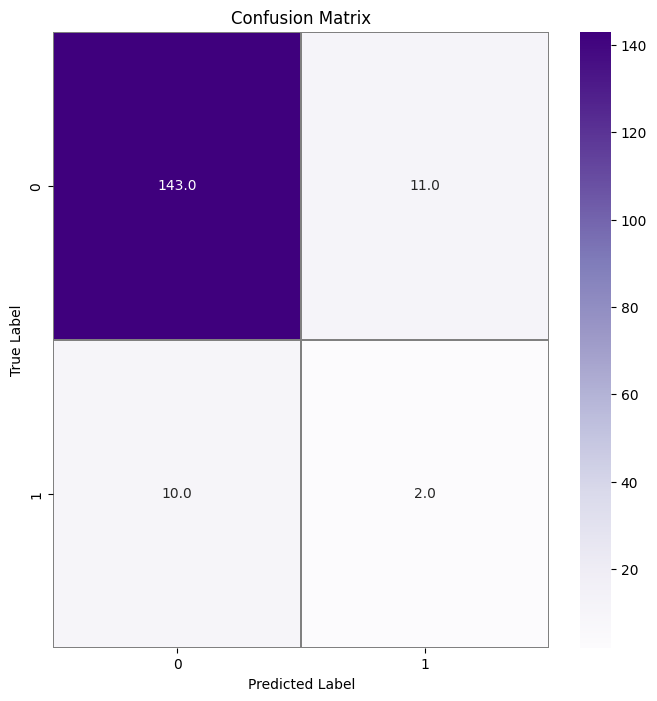

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       154
           1       0.15      0.17      0.16        12

    accuracy                           0.87       166
   macro avg       0.54      0.55      0.55       166
weighted avg       0.88      0.87      0.88       166

    Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  VGG16-no-TL                                 0.25  0.78   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.16      0.87         0.17         0.93  0.15  0.93   

    PLR  NLR  
0  2.33  0.9  


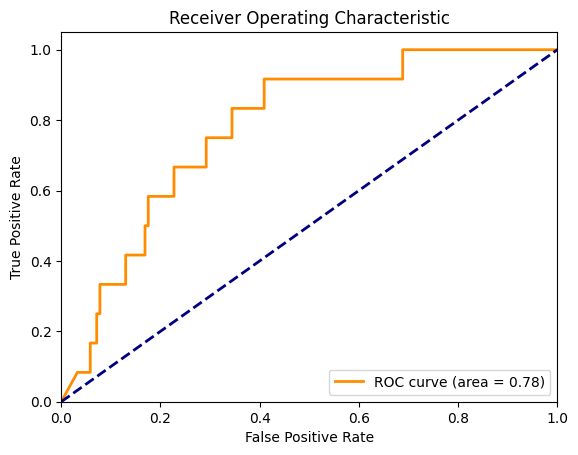

In [28]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

## 4B.3. Train Placenta Classifier with IMG AUG

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentations for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,       # random rotation
    width_shift_range=0.2,   # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,         # shear transformation
    zoom_range=0.2,          # random zoom
    horizontal_flip=True,    # random horizontal flip
    fill_mode='nearest'      # fill strategy
)

# Convert tf.data.Dataset to a format compatible with ImageDataGenerator
def get_generator(dataset, datagen):
    for images, labels in dataset:
        yield from datagen.flow(images.numpy(), labels.numpy(), batch_size=32)

In [30]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [31]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfffc51cca0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d00b87382b0> True
<keras.src.engine.functional.Functional object at 0x7d004bd027d0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d003ab5f310> True
<keras.src.layers.core.dense.Dense object at 0x7d00b87a4b50> True
<keras.src.layers.core.dense.Dense object at 0x7d00b87381f0> True
<keras.src.layers.core.dense.Dense object at 0x7d0064b41360> True


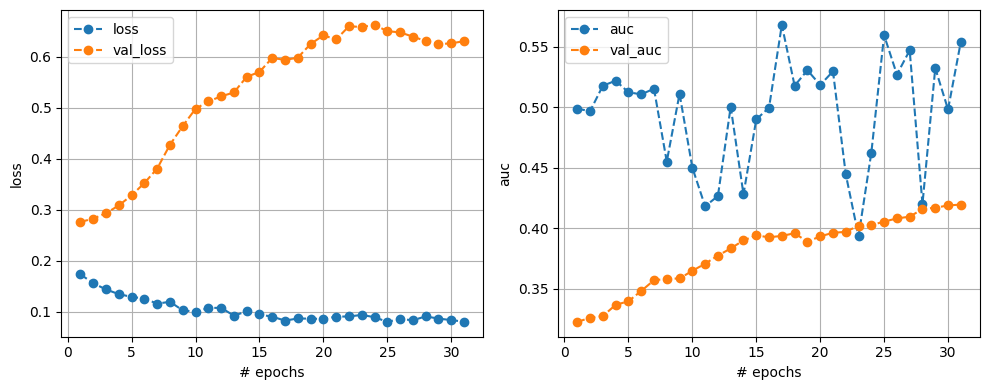

24/24 [==============================] - 6s 207ms/step - loss: 0.0804 - auc: 0.5542 - val_loss: 0.6306 - val_auc: 0.4196
Training time: 220.33585906028748 seconds


In [32]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.93: 0.00


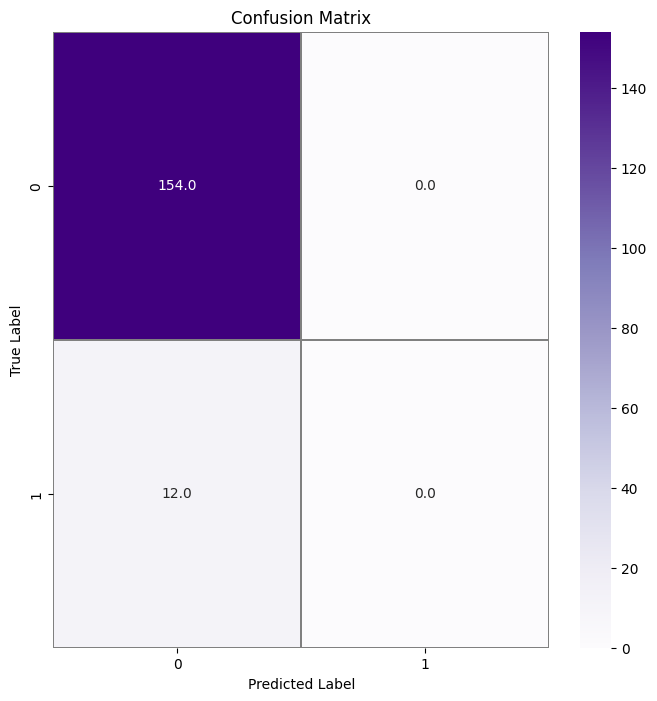

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

        Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  VGG16-no-TL-AUG                                    0  0.67   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


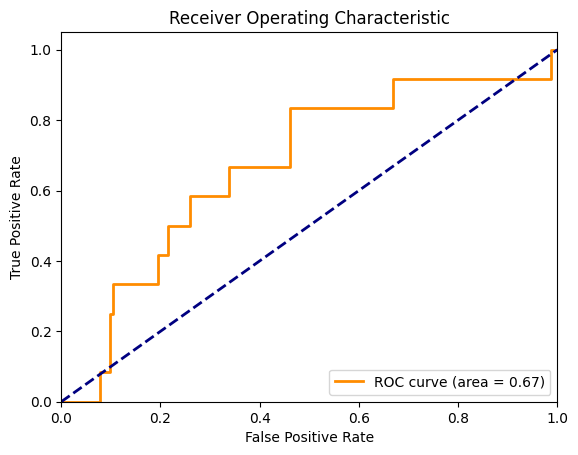

In [33]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-AUG')

## 4B.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

In [34]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

# Unfreeze four top layers 
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfffc580160> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cfffc44f550> True
<keras.src.engine.functional.Functional object at 0x7d004bd027d0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7cfffc35f370> True
<keras.src.layers.core.dense.Dense object at 0x7cfc052ec550> True
<keras.src.layers.core.dense.Dense object at 0x7d009ff2dae0> True
<keras.src.layers.core.dense.Dense object at 0x7d009ff2e350> True


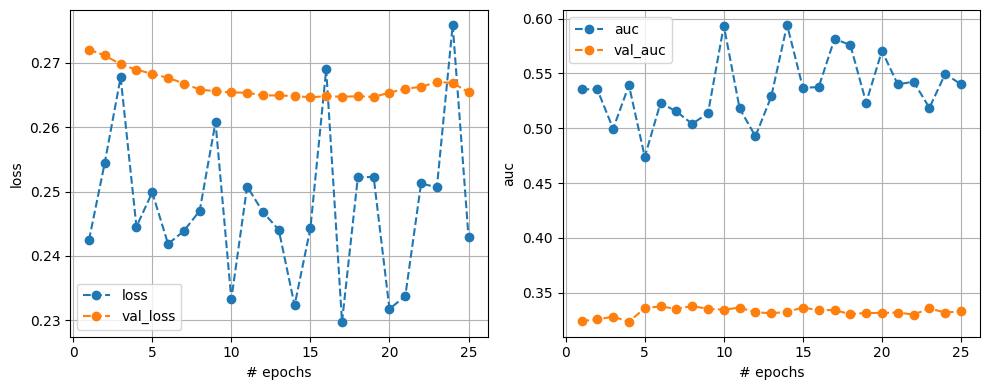

24/24 [==============================] - 6s 203ms/step - loss: 0.2429 - auc: 0.5400 - val_loss: 0.2654 - val_auc: 0.3330
Training time: 178.05141806602478 seconds


In [35]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      #class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.93: 0.08


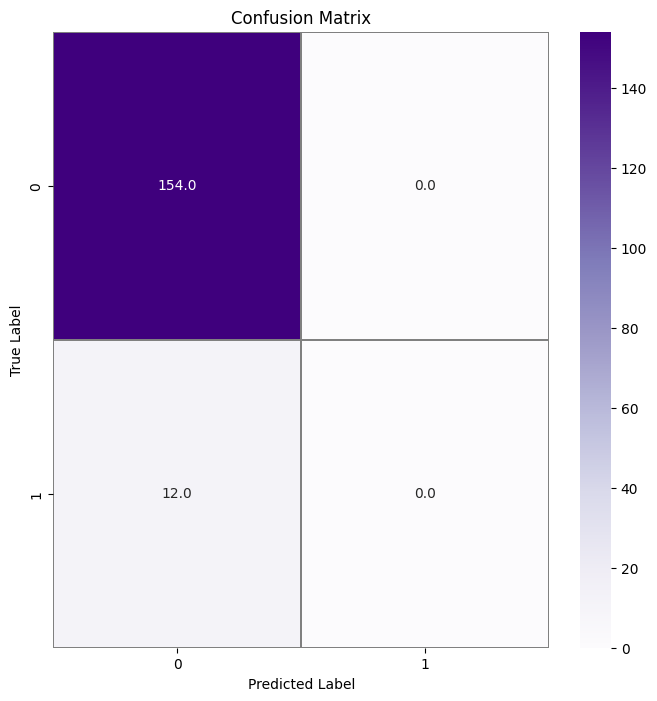

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

              Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  VGG16-no-TL-AUG-no-CW                                 0.08  0.41   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


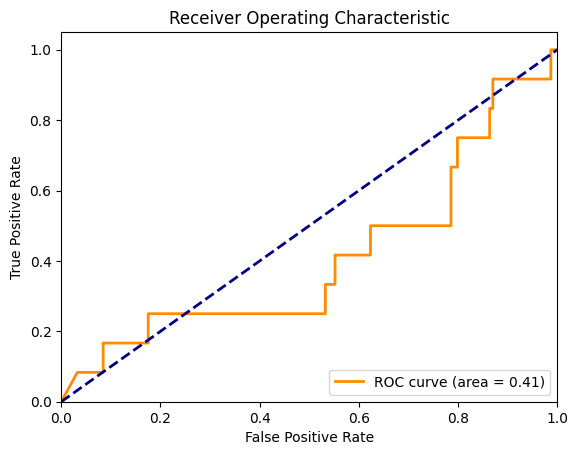

In [36]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-AUG-no-CW')

# 5. ResNet18 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on ResNet18 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [37]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [38]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5.1. Train Brains Classifier

## 5.2. Train Placenta Classifier (fine-tuning from previous model)

In [39]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

pla_prep_train_data = pla_train_data.map(preprocess_data_resnet18)
pla_prep_val_data = pla_val_data.map(preprocess_data_resnet18)
pla_prep_test_data = pla_test_data.map(preprocess_data_resnet18)

In [40]:
# create model again
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers of the model
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

44920640/44920640 [==============================] - 0s 0us/step
base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7d00b013d630> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d004bde27d0> True
<keras.src.engine.functional.Functional object at 0x7d004bdb8910> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d009ff526e0> True
<keras.src.layers.core.dense.Dense object at 0x7d004bdbb790> True
<keras.src.layers.core.dense.Dense object at 0x7d0075b782e0> True
<keras.src.layers.core.dense.Dense object at 0x7d0075b7a110> True


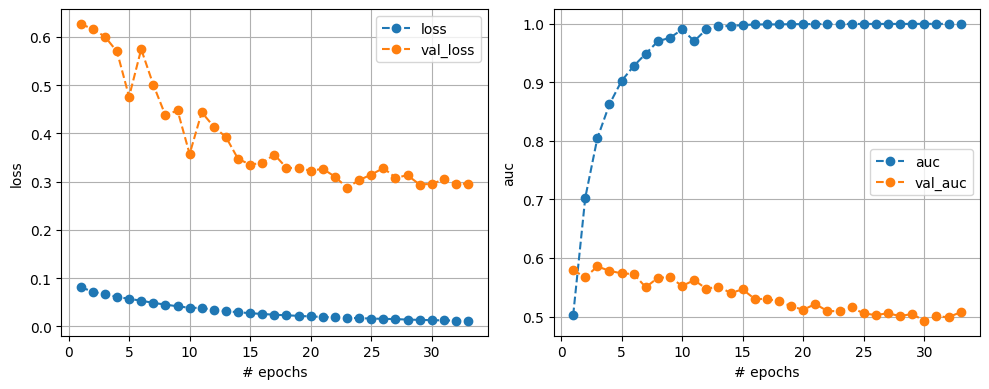

24/24 [==============================] - 4s 124ms/step - loss: 0.0115 - auc: 1.0000 - val_loss: 0.2956 - val_auc: 0.5074


In [41]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(pla_prep_train_data,
                    epochs=150,
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.93: 0.08


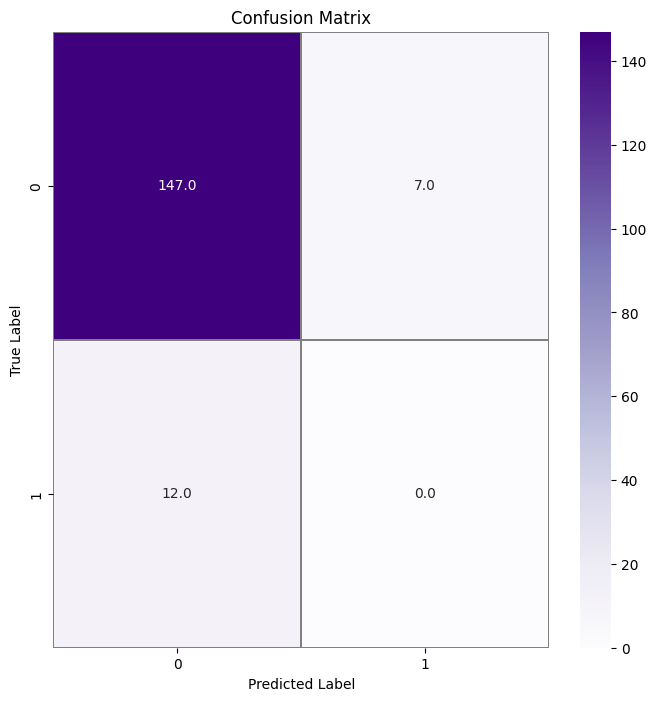

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.00      0.00      0.00        12

    accuracy                           0.89       166
   macro avg       0.46      0.48      0.47       166
weighted avg       0.86      0.89      0.87       166

    Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-TL                                 0.08  0.57   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.89          0.0         0.95  0.0  0.92   

   PLR   NLR  
0  0.0  1.05  


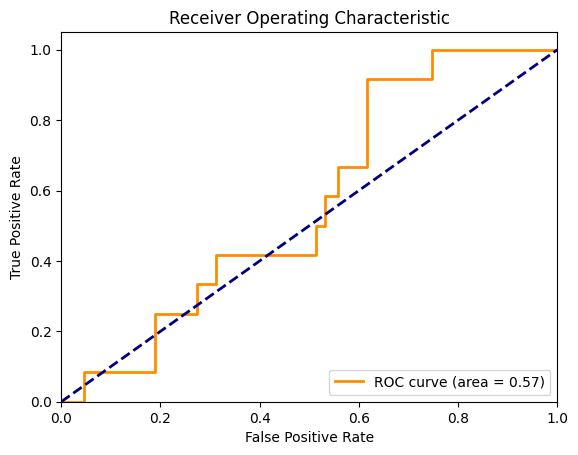

In [42]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL')

## 5.3. Train Placenta Classifier with IMG AUG (fine-tuning from previous model)

In [43]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [44]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)


base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfc04628a60> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cfffc44ddb0> True
<keras.src.engine.functional.Functional object at 0x7cfffc44f6a0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7cfffc6e47f0> True
<keras.src.layers.core.dense.Dense object at 0x7cfffc44c280> True
<keras.src.layers.core.dense.Dense object at 0x7cfc04628c10> True
<keras.src.layers.core.dense.Dense object at 0x7d0075b38070> True


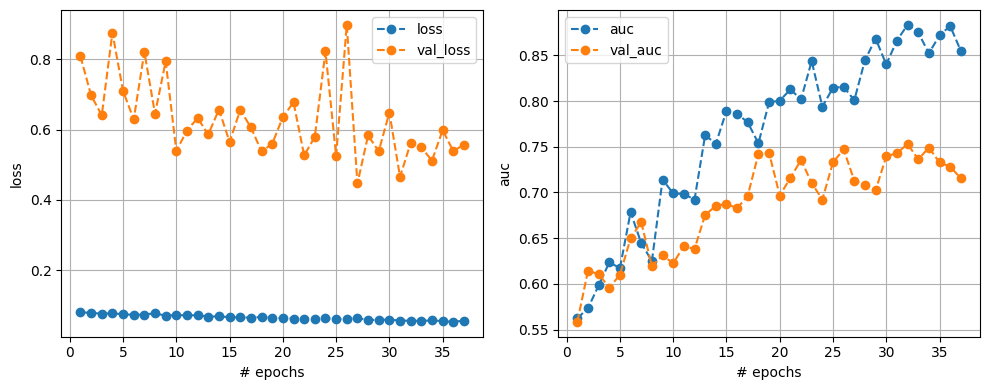

24/24 [==============================] - 4s 134ms/step - loss: 0.0566 - auc: 0.8548 - val_loss: 0.5579 - val_auc: 0.7156


In [45]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.93: 0.00


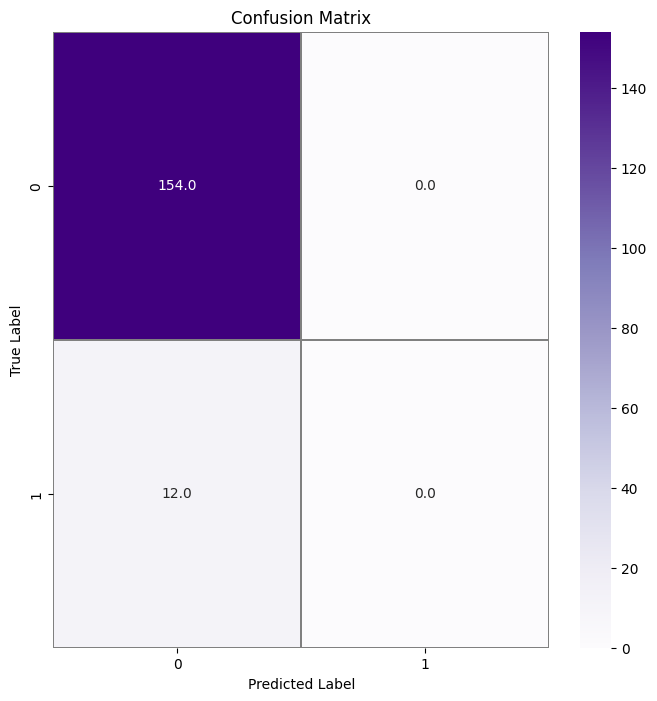

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

        Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-TL-AUG                                    0  0.47   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


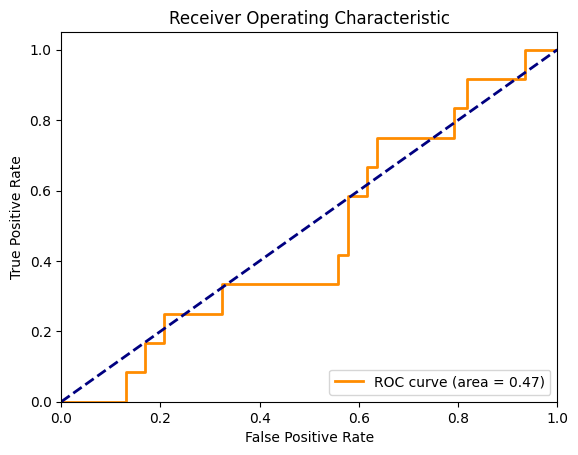

In [46]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL-AUG')

## 5.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

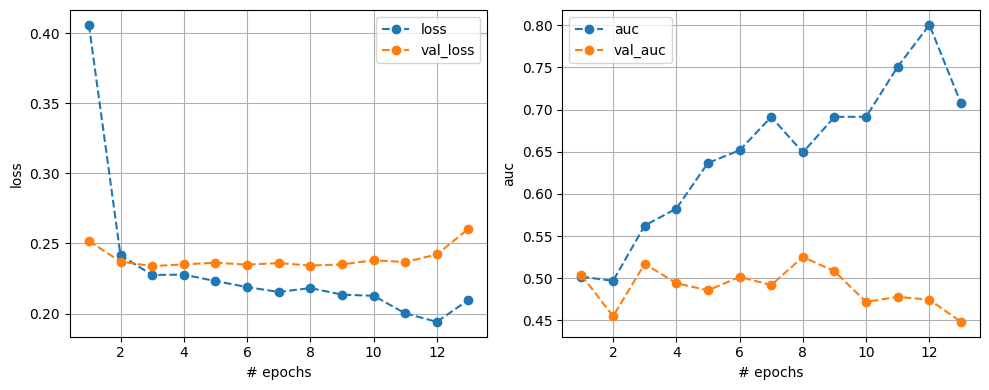

24/24 [==============================] - 4s 132ms/step - loss: 0.2097 - auc: 0.7074 - val_loss: 0.2604 - val_auc: 0.4481


In [47]:
# without class weights
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )


Max Sensitivity at Specificity >= 0.93: 0.00


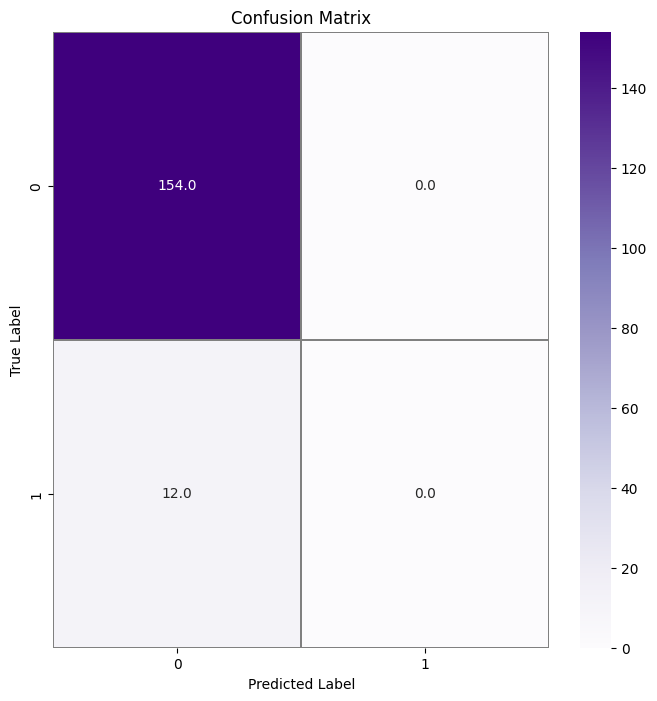

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

              Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-TL-AUG-no-CW                                    0  0.38   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


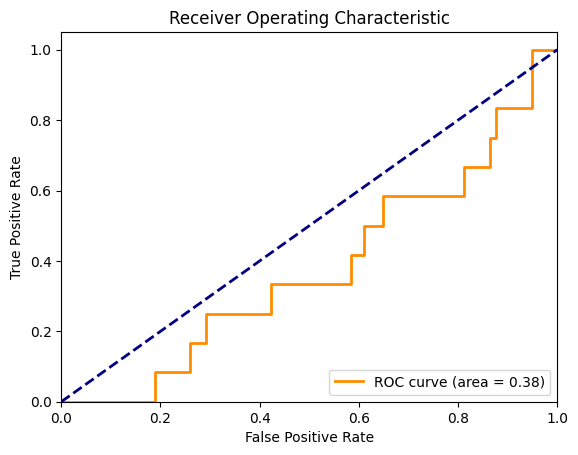

In [48]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL-AUG-no-CW')

# 5B. ResNet18 NO TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on ResNet18 architecture. Four additional custom layers are added and no layers are frozen. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from the brain classifier, and then 4 layers to fine tune the placenta images.

In [49]:
!pip install image-classifiers

In [50]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5B.1. Train Brains Classifier

## 5B.2. Train Placenta Classifier

In [51]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

pla_prep_train_data = pla_train_data.map(preprocess_data_resnet18)
pla_prep_val_data = pla_val_data.map(preprocess_data_resnet18)
pla_prep_test_data = pla_test_data.map(preprocess_data_resnet18)

In [52]:
# create model again
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

# Unfreeze four top layers of the model
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfffc35e920> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cfffc672fb0> True
<keras.src.engine.functional.Functional object at 0x7cfffc672a10> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7d00b02ff820> True
<keras.src.layers.core.dense.Dense object at 0x7cfffc671240> True
<keras.src.layers.core.dense.Dense object at 0x7d004bde0d60> True
<keras.src.layers.core.dense.Dense object at 0x7cfc076985b0> True


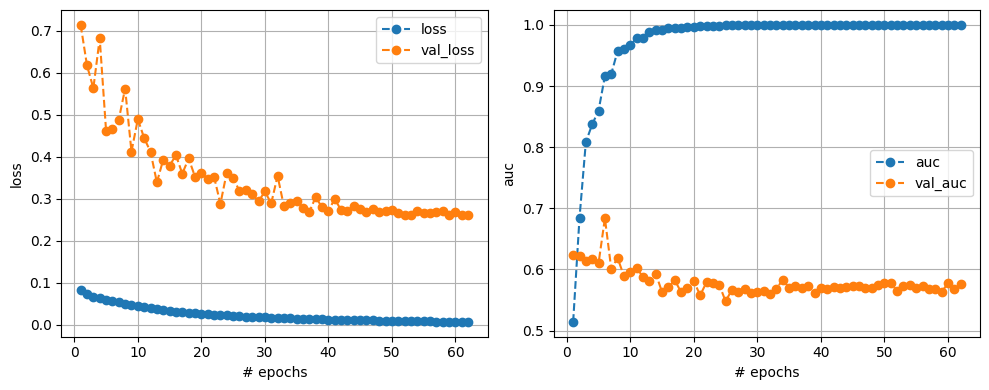

24/24 [==============================] - 4s 130ms/step - loss: 0.0063 - auc: 1.0000 - val_loss: 0.2620 - val_auc: 0.5763


In [53]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(pla_prep_train_data,
                    epochs=150,
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.93: 0.00


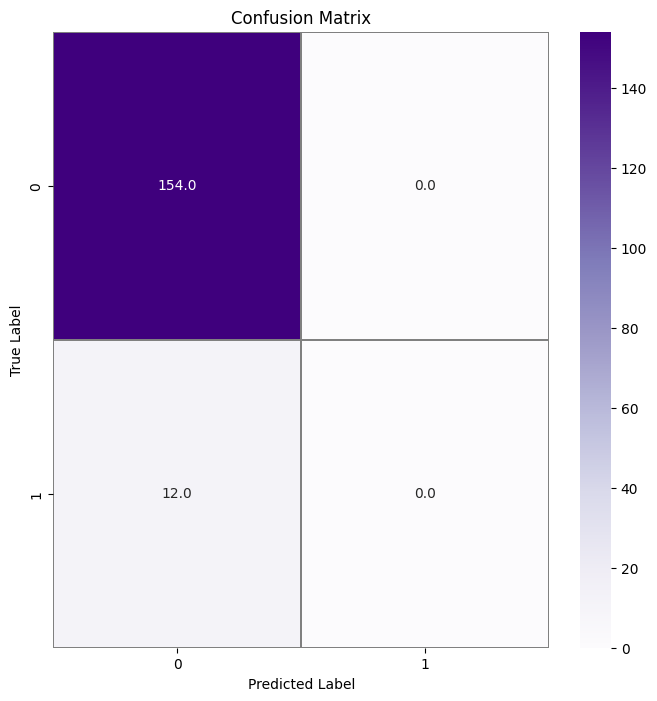

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

       Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-no-TL                                    0  0.53   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


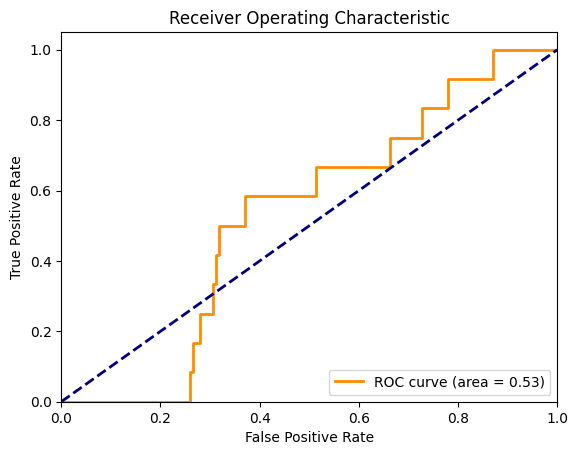

In [54]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL')

## 5B.3. Train Placenta Classifier with IMG AUG

In [55]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [56]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

base_model.trainable set to False


In [57]:
# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7d0038250f40> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cfc05528a00> True
<keras.src.engine.functional.Functional object at 0x7cfc05529e10> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7cfc054b7a90> True
<keras.src.layers.core.dense.Dense object at 0x7cfc05528f10> True
<keras.src.layers.core.dense.Dense object at 0x7cfc055292d0> True
<keras.src.layers.core.dense.Dense object at 0x7cfc05528d90> True


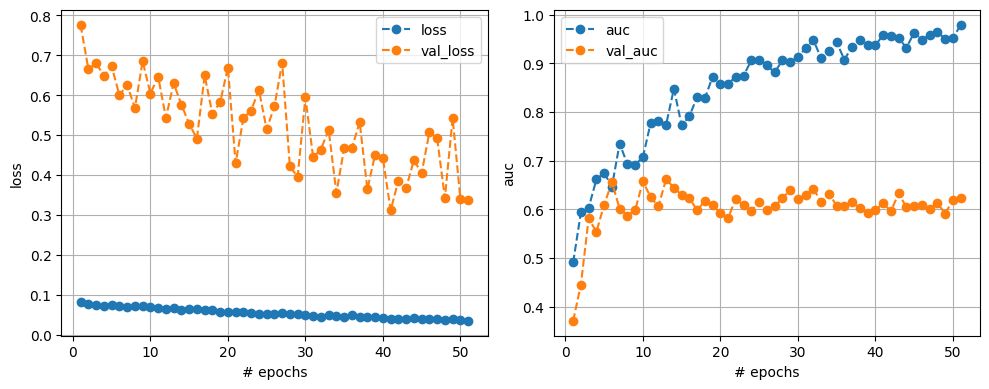

24/24 [==============================] - 4s 133ms/step - loss: 0.0355 - auc: 0.9788 - val_loss: 0.3385 - val_auc: 0.6237


In [58]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.93: 0.25


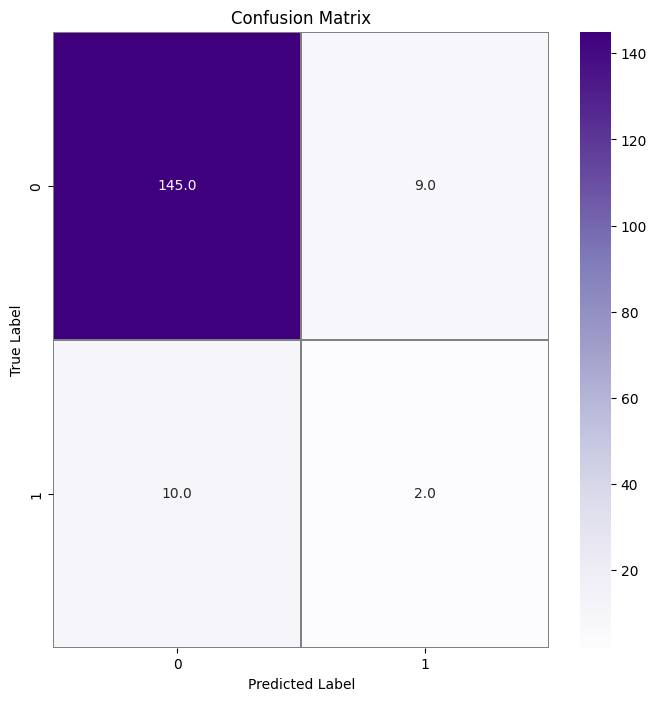

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       154
           1       0.18      0.17      0.17        12

    accuracy                           0.89       166
   macro avg       0.56      0.55      0.56       166
weighted avg       0.88      0.89      0.88       166

           Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-no-TL-AUG                                 0.25  0.63   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.17      0.89         0.17         0.94  0.18  0.94   

    PLR   NLR  
0  2.85  0.89  


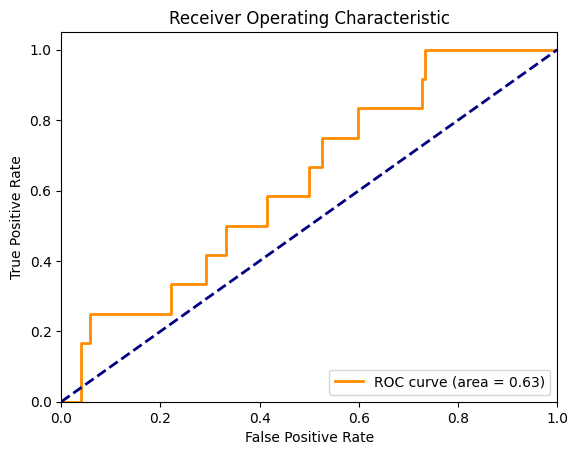

In [59]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-AUG')

## 5B.4. Train Placenta Classifier with IMG AUG and no class weights

In [60]:
# without class weights
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7cfc06fcee00> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d003ab25de0> True
<keras.src.engine.functional.Functional object at 0x7d003ab25ea0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7cfc0430d8d0> True
<keras.src.layers.core.dense.Dense object at 0x7d003aad3730> True
<keras.src.layers.core.dense.Dense object at 0x7cfc06fce920> True
<keras.src.layers.core.dense.Dense object at 0x7cfc05423610> True


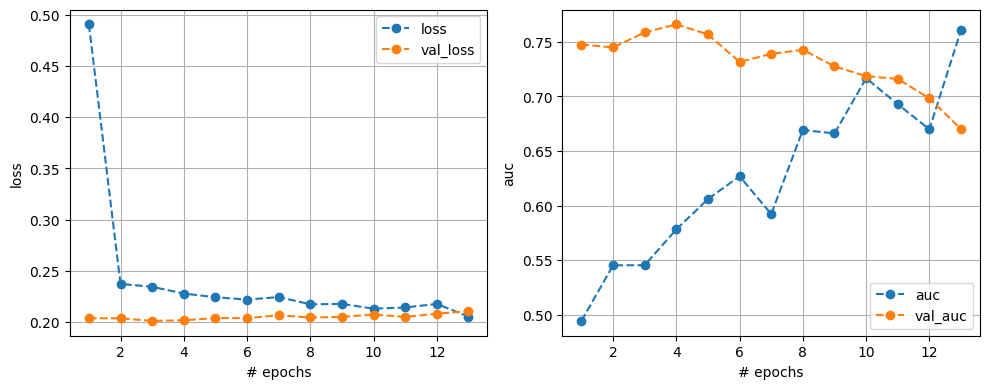

24/24 [==============================] - 4s 135ms/step - loss: 0.2054 - auc: 0.7607 - val_loss: 0.2107 - val_auc: 0.6700


In [61]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=pla_class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.93: 0.00


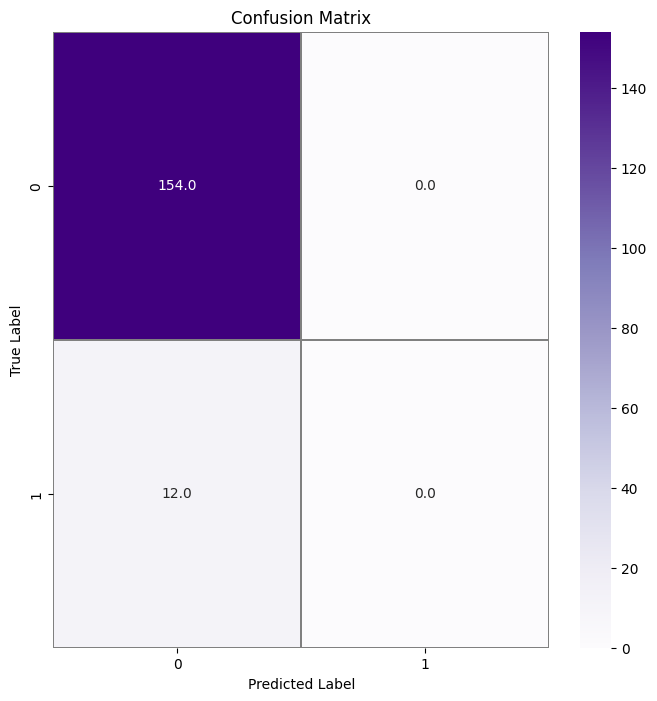

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

             Model Name  Max Sensitivity at Specificity 0.93  AUC  \
0  ResNet18-no-TL-no-CW                                    0  0.4   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


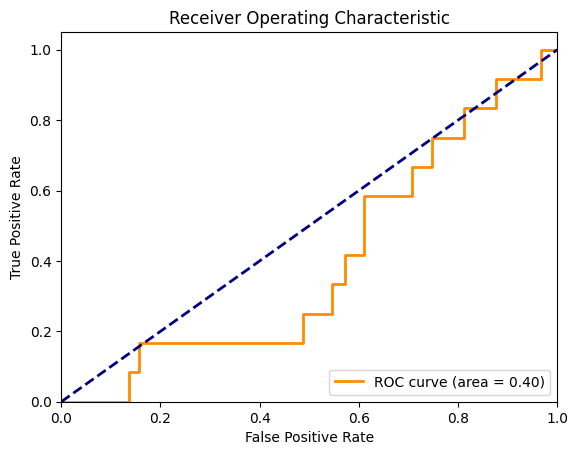

In [62]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-no-CW')